# Comparing blood plasma and blood serum with different numbers of samples

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Classification_Utils as cu
import MaxQuant_Postprocessing_Functions as mq
import numpy as np
from os import listdir
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib
import time

## Load and clean data

In [3]:
BLOOD_DERIVATIVES_DIR = 'F:\Serum_And_Plasma\\'

files_dir = BLOOD_DERIVATIVES_DIR
file_paths = listdir(files_dir) 

df = cu.combine_csvs(files_dir, file_paths)
df = df.drop(['\n'])

original_df = df.copy()

In [4]:
mq.log2_normalize(df)

df_min = df.min().min()
impute_val = df_min/2
df = df.fillna(impute_val)

mq.median_normalize(df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:150: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,:] = np.log2(df.iloc[:,:])


## Map each column to a corresponding label

In [5]:
tissues = ['Blood_Plasma', 'Blood_Serum']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [6]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

In [7]:
df = cu.keep_percentile_features(df, labels, 100)
features_to_keep = df.index.values.tolist()

df.shape

(23814, 100)

## PCA plot, Pearson

image_dir = r'D:\Images\Blood_Derivatives\\'

column_to_color = mq.map_colors(tissues, tissues_to_columns, 4)

mq.make_seaborn_boxplot(df, image_dir, 'Median_normalized_boxplots', column_to_color)

scaled_data = df.T

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe

pca_3 = PCA(n_components=3) 
pca_3.fit(scaled_data)
pca_data_3 = pca_3.transform(scaled_data)

per_var, pca_labels = mq.make_scree_plot(pca, image_dir)
per_var_3, pca_labels_3 = mq.make_scree_plot(pca_3, image_dir, '3 Dimensional Scree')

mq.draw_pca_graph2(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, tissues, tissues_to_columns, 'Blood Derivatives PCA')

mq.draw_3d_pca(column_names, pca_data_3, image_dir, column_to_color, per_var_3, pca_labels_3, tissues, tissues_to_columns, 'Blood Derivatives 3D PCA')

## Classify

In [10]:
NUM_SPLITS = 100
transformed_df = df.T

In [11]:
knn = cu.knn_model_crossval(transformed_df, labels, NUM_SPLITS)

accuracy: 0.97 (+/- 0.06)


In [12]:
lr = cu.logistic_regression_model_crossval(transformed_df, labels, NUM_FOLDS)

accuracy: 0.99 (+/- 0.03)


In [13]:
gnb = cu.bayes_gaussian_model_crossval(transformed_df, labels, NUM_SPLITS)

accuracy: 1.00 (+/- 0.00)


In [14]:
mnb = cu.bayes_multinomial_model_crossval(transformed_df, labels, NUM_SPLITS)

accuracy: 0.99 (+/- 0.03)


In [15]:
svc_models = cu.SVC_models_crossval(transformed_df, labels, NUM_SPLITS)

accuracy: 0.98 (+/- 0.04)
accuracy: 0.98 (+/- 0.03)
accuracy: 0.50 (+/- 0.00)
accuracy: 0.97 (+/- 0.05)


In [18]:
rf = cu.randomforest_model_crossval(transformed_df, labels, NUM_SPLITS)

accuracy: 0.99 (+/- 0.04)


In [19]:
gbc = cu.gradient_boosting_crossval(transformed_df, labels, NUM_SPLITS)

accuracy: 0.99 (+/- 0.03)


### Save Models, train data, train features

In [24]:
finalized_model_folder = r'Trained_Models\Plasma_Serum_Thresholding\\'
num_samples = 50

In [25]:
models = [knn, lr, gnb, mnb, svc_models[0], rf, gbc]
model_names = ['knn', 'lr', 'gnb', 'mnb', 'svc', 'rf', 'gbc']

for model, name in zip(models, model_names):
    model_path = finalized_model_folder + name + '_' + str(num_samples) + '_samples.pkl'
    joblib.dump(model, open(model_path, 'wb')) 

In [26]:
features_path = finalized_model_folder + 'train_features.pkl'
joblib.dump(features_to_keep, open(features_path, 'wb'))

data_path = finalized_model_folder + 'train_data_' + str(num_samples) + '_samples.pkl'
joblib.dump(original_df, open(data_path, 'wb'))

## Load Test Data

In [29]:
TEST_SET_DIR = 'F:\Serum_Plasma_Testset\\'

In [30]:
test_paths = listdir(TEST_SET_DIR) 
test_df = cu.combine_csvs(TEST_SET_DIR, test_paths)

test_labels = []
for col in test_df.columns.values.tolist():
    for tissue in tissues:
        if col.startswith(tissue):
            test_labels.append(tissue)
            continue
            
test_df = cu.fit_new_data(original_df, test_df, features_to_keep)

C:\Users\kush494\Documents\Proteomics_Data_Processing\Classifiers\Classification_Utils.py:523: RuntimeWarning: divide by zero encountered in log2
  fitted_data.iloc[:,:] = np.log2(fitted_data.iloc[:,:])


## Test on Test Set

In [32]:
svc = svc_models[0]

In [33]:
mnb_pred = mnb.predict(test_df)
mnb_result = mnb.score(test_df, test_labels)

lr_pred = lr.predict(test_df)
lr_result = lr.score(test_df, test_labels)

svc_pred = svc.predict(test_df)
svc_result = svc.score(test_df, test_labels)

gnb_pred = gnb.predict(test_df)
gnb_result = gnb.score(test_df, test_labels)

gbc_pred = gbc.predict(test_df)
gbc_result = gbc.score(test_df, test_labels)

rf_pred = rf.predict(test_df)
rf_result = rf.score(test_df, test_labels)

knn_pred = knn.predict(test_df)
knn_result = knn.score(test_df, test_labels)

In [34]:
print(lr_result)
print(mnb_result)
print(rf_result)
print(svc_result)
print(gbc_result)
print(gnb_result)
print(knn_result)

0.5
0.45
0.5
0.5
0.5
0.5
0.45


## Confusion Matrix

Confusion matrix, without normalization
[[ 9  1]
 [10  0]]
Normalized confusion matrix
[[ 0.9  0.1]
 [ 1.   0. ]]


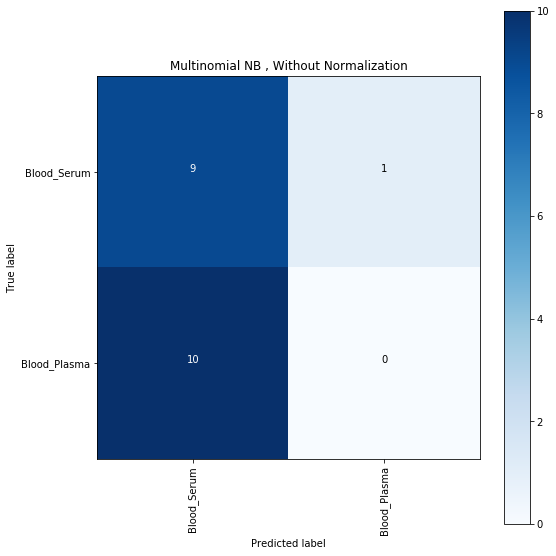

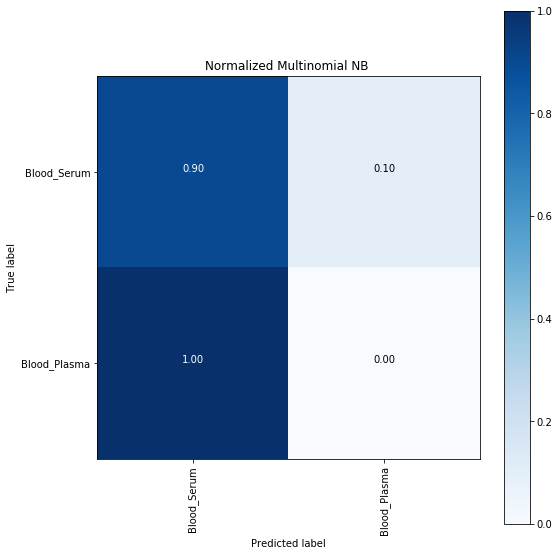

In [35]:
cm_labels = list(set(mnb_pred.tolist() + test_labels))
cu.show_confusion_matrices(test_labels, mnb_pred, cm_labels, 'Multinomial NB ')